# Pool Ball Position Estimator

So a few years ago, i tried to read a popular account about Baye's Rule: [*The Theory That Would Not Die*](https://www.amazon.com/Theory-That-Would-Not-Die-ebook/dp/B0050QB3EQ/ref=tmm_kin_swatch_0?_encoding=UTF8&qid=&sr=).
Like most books of its type, it tried real hard not to use any equations, resulting in a mess of hand-waving interspersed with historical details.
I didn't get much out of it and, apparently, [I'm not the only one](http://www.popularscience.co.uk/reviews/rev654.htm).

But it had one introductory example that interested me: a person stands with his back to a pool table with the cue ball placed on it, and he tries to determine its position knowing nothing more than whether other randomly rolled balls stop to the left or right of it.

![Pool Ball Position Estimation Problem](pool-table.png)

I could see how to do that from a [frequentist viewpoint](https://en.wikipedia.org/wiki/Frequentist_inference) by looking at the proportion of the balls ending up to the left and right. But how certain was the estimate after a given number of left/right trials? I guess I could figure that out, but it would probably involve probability distributions and integration, so **NO**.

Then a few months ago, I saw a video by Allen Downey about Bayesian statistics (maybe it was [this one](https://www.youtube.com/watch?v=R6d-AbkhBQ8)) and I got enough from that to "solve" the pool ball problem.
(I say "solve" because I can compute the probabilities but I don't have a closed-form, analytical expression for them.)
This notebook shows how.


## Problem Setup

To set up the problem, we'll start with some definitions. Otherwise we'll end up with more hand-waving.

* $B_L$: The coordinate of the left  edge of the pool table(usually zero).
* $B_R$: The coordinate of the right edge of the pool table.
* $x$: The actual (but unknown to the person) position of the cue ball placed on the pool table $B_L \le x \le B_R$.

Then there are two possible events depending upon whether a randomly-rolled pool ball ends up to the left or right of the cue ball:

* $L$: The randomly-rolled ball comes to rest to the left of the cue ball.
* $R$: The randomly-rolled ball comes to rest to the right of the cue ball.

Each event has a probability that it will occur, $P(L)$ and $P(R)$, and these are easy to compute,
but we'll see later we don't really need to.

Next there is the *prior probability* which is merely a guess of where the cue ball is.
To keep things simple, we'll assume the cue ball is at one point in a discrete set of evenly-spaced points
between the left and right edges of the pool table:
* $P(i)$: The probability the cue ball is at position $i$ where $B_L \le i \le B_R$.

Then there is the *posterior probability* which is an update of the prior based on whether an $L$ or $R$ event occurred.
The posterior should start to "hump up" around $x$ as more and more events occur and the position of the cue ball becomes
more and more certain.
* $P(i|L)$: The probability the cue ball is at position $i$ given that an $L$ event occurred.
* $P(i|R)$: The probability the cue ball is at position $i$ given that an $R$ event occurred.

The posterior is what we want because it shows where the cue ball is more likely to be located,
but it's not obvious how to compute it. If it was, we wouldn't need Baye's rule:

$$P(i|L)P(L) = P(L|i)P(i)$$

$$P(i|L) = \frac{P(L|i)P(i)}{P(L)}$$

So we can find $P(i|L)$ and $P(i|R)$ if we just have the opposite conditional probabilities $P(L|i)$ and $P(R|i)$.
Luckily, those are easy to compute in this example:
* $P(L|i)$: The probability an $L$ event will occur if the cue ball is at position $i$. Assuming the random rolling procedure follows a uniform distribution in the range $[B_L, B_R]$, then $P(L|i) = \frac{i - B_L}{B_R - B_L}$. So as the cue ball is placed further to the right (i.e., $i$ gets closer to $B_R$), then the probability a randomly rolled ball ends up to the left gets higher.
* $P(R|i)$: The probability an $R$ event will occur if the cue ball is at position $i$. Obviously, $P(R|i) = 1 - P(L|i)$ because if the rolled ball is not to the left, then it has to be to the right.


## Algorithm

Now the procedure for computing the cue ball position probabilities is:

1. Pick values $B_L$, $B_R$ for the pool table length and place the cue ball at position $x$.
1. Select $N$ points between $B_L$ and $B_R$. Each point will have a position $i$ and a corresponding probability $P(i)$.
1. Since the estimator starts off with no idea where the cue ball is located, the initial prior probability at each point is set to $1/N$.
1. Simulate rolling a ball by generating a uniformly-distributed random number between $B_L$ and $B_R$. This will generate an $L$ or $R$ event depending upon whether the random number is less-than or greater-than $x$.
1. At each point, generate the posterior probability as follows:
    * If event $L$ occurs: $$P(i|L) = \frac{P(L|i)P(i)}{P(L)} = \frac{i - B_L}{B_R - B_L} \times \frac{1}{N} \times \frac{1}{P(L)}$$.
    * If event $R$ occurs: $$P(i|R) = \frac{P(R|i)P(i)}{P(L)} = \frac{B_R - i}{B_R - B_L} \times \frac{1}{N} \times \frac{1}{P(R)}$$.
    
   It's worth noting that:
   $$\sum_{i}P(i|L) = \sum_{i}\frac{P(L|i)P(i)}{P(L)} = \frac{1}{P(L)}\sum_{i}P(L|i)P(i) = 1$$
   $$\sum_{i}P(L|i)P(i) = P(L)$$
   So as I said above, we don't need to know how to specifically compute $P(L)$ (or, for the same reason, $P(R)$).
   Just normalize using the summation.
   
The steps listed above will update the initial prior probability to find the posterior probability
based on the event generated by randomly rolling a single ball.
But then what?
When a second ball is rolled, where do we get the prior probability distribution to plug into the above procedure?

The answer, of course, is simple: *use the posterior probability that was calculated from the previous ball roll.*
It already incorporates the information gleaned from that event, so using it as the prior for the second ball
roll will add more information and further refine the estimate of where the cue ball was placed. Then use that posterior
as the prior for the next iteration and so on.

![Iterative Update of Priors and Posteriors](iter-update.png)


# Code

With all the theory out of the way, now it's time to write some code.
First, we create a class for storing and updating the probabilities for the cue ball's position:

In [51]:
from random import uniform
import numpy as np
from numpy.linalg import norm

class PoolBallPositionEstimator:
    def __init__(self, x, B_L=0, B_R=100, N=101):
        self.x = x       # Cue ball position.
        self.B_L = B_L   # Left edge of pool table.
        self.B_R = B_R   # Right edge of pool table.
        
        # Create an array of tuples where each tuple stores 1) a position on the
        # pool table and 2) the probability of the cue ball being at that position.
        self.estimates = np.zeros(N, dtype=[('pos','f4'),('prob','f4')])
        
        # Evenly distribute the points between the left and right edges of the table.
        self.estimates['pos'] = np.linspace(B_L, B_R, N)
        
        # Set the initial prior at each point to 1/N.
        self.estimates['prob'] = np.full(N, 1.0/N)
        
    def roll_ball(self):
        # Return the position of a ball rolled onto the pool table with a
        # uniform distribution between the left and right edges.
        return uniform(self.B_L, self.B_R)
        
    def update(self,roll):
        # Update the probabilities at each point for a particular roll of a ball.
        interval = self.B_R - self.B_L
        
        if roll > self.x:
            # Update the probabilities for an 'R' event.
            self.estimates['prob'] *= (self.B_R - self.estimates['pos']) / interval
            
        else:
            # Update the probabilites for an 'L' event.
            self.estimates['prob'] *= self.estimates['pos'] / interval
            
        # Normalize the probabilities.
        self.estimates['prob'] /= norm(self.estimates['prob'], ord=1)


Now we can create an instance of the class, iteratively provide it with ball-rolling events, and
watch the effects on the probability distribution:

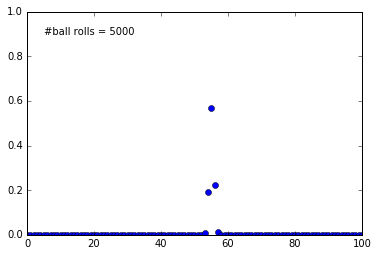

In [52]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import rc
from IPython.display import HTML

# Create an instance with the cue ball set at position 55.
pbpe = PoolBallPositionEstimator(x=55)

num_rolls = 0  # Counter for the number of ball-rolling events.

# Setup a plot of the probability distribution.
fig, ax = plt.subplots()
ax.set_ylim([0.0,1.0])
distr, = ax.plot(pbpe.estimates['pos'], pbpe.estimates['prob'], 'bo')
iters = ax.text(5,0.9,'')

def set_plot_data():
    # Place the probability values into the plot.
    distr.set_ydata(pbpe.estimates['prob'])  # update the data
    
    # Update the display of the number of ball roll events.
    iters.set_text('#ball rolls = {}'.format(num_rolls))
    
    return distr, iters  # Return updated plot elements.

def roll_balls(i):
    global num_rolls
    
    # Perform a number of ball rolls and update the probabilities.
    for _ in range(10):
        # Roll a ball and update the probabilities.
        pbpe.update(pbpe.roll_ball())
        num_rolls += 1  # Update the number of ball rolls.
        
    # Update the plot with the new probabilities.
    return set_plot_data()

# Animate the evolution of the probabilities over a number of ball rolls.
anim = animation.FuncAnimation(fig, roll_balls, range(500), init_func=set_plot_data,
                              interval=30, blit=True)

# Create a video of the animation.
rc('animation',html='html5')
HTML(anim.to_html5_video())

# Display the animation.
anim

The animation shows the cue ball position is localized between 50 and 60 after approximately 500 ball rolls. Then the convergence slows down. After 3500 rolls, the cue ball is pinned down between 53 and 57.

The convergence could be sped up by tightening the allowable range of the ball rolls to the region containing the bulk
of the probability distribution at any given iteration. But that's secondary to my main purpose which was to
gain experience with Baye's Rule for this simple problem.
Since I've done that, I'll conclude this notebook.